<a href="https://colab.research.google.com/github/ktcraig/Project-1-AI-Class/blob/Katie-Craig-Branch/Money_Miners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Install the required libraries
!pip install prophet

In [43]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet
from matplotlib import pyplot as plt
import gdown
%matplotlib inline

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
#URL for downloading bitcoin data
url_bitcoin = 'https://drive.google.com/uc?id=1g_bLlJpB0B9TkPEnTwCmeGlhZVqTOZ5L'
gdown.download(url_bitcoin, 'Bitcoin_Data.csv', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1g_bLlJpB0B9TkPEnTwCmeGlhZVqTOZ5L
To: /content/Bitcoin_Data.csv
100%|██████████| 161k/161k [00:00<00:00, 53.7MB/s]


'Bitcoin_Data.csv'

In [46]:
#URL for downloading for SP500 data
url_sp500 = 'https://drive.google.com/uc?id=1kL74LliyVXjr8UiwH7Wa6Td6Z4HLhY9i'
gdown.download(url_sp500, 'SP500_Data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1kL74LliyVXjr8UiwH7Wa6Td6Z4HLhY9i
To: /content/SP500_Data.csv
100%|██████████| 111k/111k [00:00<00:00, 71.8MB/s]


'SP500_Data.csv'

In [47]:
#URL for downloading for gold data
url_gold = 'https://drive.google.com/uc?id=1Xn0QmR6paT0pxeX7UEiwb_Y6NvP23N0Q'
gdown.download(url_gold, 'Gold_Data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Xn0QmR6paT0pxeX7UEiwb_Y6NvP23N0Q
To: /content/Gold_Data.csv
100%|██████████| 114k/114k [00:00<00:00, 74.6MB/s]


'Gold_Data.csv'

In [48]:
#Read the URL_Bitcoin into a dataframe
bitcoin_df = pd.read_csv(url_bitcoin,
                 index_col="Date",
                 parse_dates=True
                )

# Drop any values that are blank
bitcoin_df = bitcoin_df.dropna()

# Drop Column '% Change'
bitcoin_df = bitcoin_df.drop(columns="Change %")

# Preview the dataset
bitcoin_df.head()

,Price,Open,High,Low,Vol.
Date,,,,,
2024-12-09,"97,359.4","101,129.7","101,198.6","94,395.8",321.01K
2024-12-08,"101,115.8","99,837.0","101,339.9","98,713.9",128.93K
2024-12-07,"99,837.0","99,757.2","100,441.8","98,969.0",118.44K
2024-12-06,"99,760.7","96,968.9","101,908.5","96,452.0",213.49K
2024-12-05,"96,970.8","98,624.8","103,719.4","92,510.4",245.79K


In [49]:
#Read the URL_SP500 into a dataframe
sp500_df = pd.read_csv(url_sp500,
                 index_col="Date",
                 parse_dates=True
                )

# Drop any values that are blank
sp500_df = sp500_df.dropna()

# Preview the dataset
sp500_df.head()
sp500_df.tail()

,Close/Last,Open,High,Low
Date,,,,
2014-12-19,2070.65,2061.04,2077.85,2061.03
2014-12-18,2061.23,2018.98,2061.23,2018.98
2014-12-17,2012.89,1973.77,2016.75,1973.77
2014-12-16,1972.74,1986.71,2016.89,1972.56
2014-12-15,1989.63,2005.03,2018.69,1982.26


In [50]:
# Read the URL_GOLD, with the first column as row index.

gold_df = pd.read_csv(url_gold,
                 index_col="Date",
                 parse_dates=True
                )

# Drop any values that are blank.

gold_df = gold_df.dropna()

# Preview the dataset.

gold_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-12-12,"2,748.30","2,753.51","2,760.91","2,743.49",1.62K,-0.30%
2024-12-11,"2,756.70","2,721.20","2,759.70","2,719.10",264.99K,1.41%
2024-12-10,"2,718.40","2,684.40","2,721.70","2,680.70",181.51K,1.21%
2024-12-09,"2,685.80","2,665.00","2,700.00","2,649.70",182.15K,0.99%
2024-12-06,"2,659.60","2,655.00","2,667.90","2,635.60",167.17K,0.42%


In [51]:
# For Bitcoin_df, clean the columns of the data
bitcoin_df.columns = ["Price", "Open", "High", "Low", "Volume"]
bitcoin_df.head()

,Price,Open,High,Low,Volume
Date,,,,,
2024-12-09,"97,359.4","101,129.7","101,198.6","94,395.8",321.01K
2024-12-08,"101,115.8","99,837.0","101,339.9","98,713.9",128.93K
2024-12-07,"99,837.0","99,757.2","100,441.8","98,969.0",118.44K
2024-12-06,"99,760.7","96,968.9","101,908.5","96,452.0",213.49K
2024-12-05,"96,970.8","98,624.8","103,719.4","92,510.4",245.79K


In [52]:
# For SP500_df, clean the columns of the SP500data
sp500_df.columns = ["Price", "Open", "High", "Low"]
sp500_df.head(5)

,Price,Open,High,Low
Date,,,,
2024-12-13,6051.09,6068.17,6078.58,6035.77
2024-12-12,6051.25,6074.29,6079.68,6051.25
2024-12-11,6084.19,6060.15,6092.59,6060.15
2024-12-10,6034.91,6057.59,6065.40,6029.89
2024-12-09,6052.85,6083.01,6088.51,6048.63


In [53]:
# For Gold_Df, clean the columns of the data
gold_df.columns = ["Price", "Open", "High", "Low", "Volume", "Change %"]
gold_df =  gold_df.drop(columns="Volume")
gold_df.head()

,Price,Open,High,Low,Change %
Date,,,,,
2024-12-12,"2,748.30","2,753.51","2,760.91","2,743.49",-0.30%
2024-12-11,"2,756.70","2,721.20","2,759.70","2,719.10",1.41%
2024-12-10,"2,718.40","2,684.40","2,721.70","2,680.70",1.21%
2024-12-09,"2,685.80","2,665.00","2,700.00","2,649.70",0.99%
2024-12-06,"2,659.60","2,655.00","2,667.90","2,635.60",0.42%


In [54]:
# For Bitcoin_df, Convert the Price column to numeric and ignore the comma
bitcoin_df['Price'] = bitcoin_df['Price'].str.replace(',', '').astype(float)
bitcoin_df['Open'] = bitcoin_df['Open'].str.replace(',', '').astype(float)
bitcoin_df['High'] = bitcoin_df['High'].str.replace(',', '').astype(float)
bitcoin_df['Low'] = bitcoin_df['Low'].str.replace(',', '').astype(float)

In [55]:

# Create a function to convert K, M and B
def convert_k_to_number(value):
  if isinstance(value, str) and 'K' in value:
    return float(value.replace('K', '')) * 1000
    return float(value)

  if isinstance(value, str) and 'M' in value:
    return float(value.replace('M', '')) * 1000000
    return float(value)

  if isinstance(value, str) and 'B' in value:
    return float(value.replace('B', '')) * 1000000000
    return float(value)

# Apply the function to the Volume Column
bitcoin_df['Volume'] = bitcoin_df['Volume'].apply(convert_k_to_number)

In [56]:
#For SP500_DF, Convert the Price column to numeric
sp500_df['Price'] = sp500_df['Price'].astype(float)
sp500_df['Open'] = sp500_df['Open'].astype(float)
sp500_df['High'] = sp500_df['High'].astype(float)
sp500_df['Low'] = sp500_df['Low'].astype(float)
sp500_df.dtypes


,0
Price,float64
Open,float64
High,float64
Low,float64


In [57]:
# For Gold_DF, Convert the Price column to numeric and ignore the comma
gold_df['Price'] = gold_df['Price'].str.replace(',', '').astype(float)
gold_df['Open'] = gold_df['Open'].str.replace(',', '').astype(float)
gold_df['High'] = gold_df['High'].str.replace(',', '').astype(float)
gold_df['Low'] = gold_df['Low'].str.replace(',', '').astype(float)

gold_df.head()

,Price,Open,High,Low,Change %
Date,,,,,
2024-12-12,2748.3,2753.51,2760.91,2743.49,-0.30%
2024-12-11,2756.7,2721.20,2759.70,2719.10,1.41%
2024-12-10,2718.4,2684.40,2721.70,2680.70,1.21%
2024-12-09,2685.8,2665.00,2700.00,2649.70,0.99%
2024-12-06,2659.6,2655.00,2667.90,2635.60,0.42%


In [80]:
# For Bitcoin_DF, Sort the dataframe by Volume values
bitcoin_df = bitcoin_df.sort_values(by='Volume', ascending=True)
bitcoin_df.head(8)


,Date,Price,Open,High,Low,Volume,Stock Volatility
0,2021-08-03,38130.3,39167.4,39766.6,37688.2,260.0,NaN
1,2020-12-25,24689.6,23728.7,24778.9,23445.3,2400.0,NaN
2,2021-08-16,45996.3,46991.6,48002.4,45672.1,2410.0,NaN
3,2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0,10692.556843
4,2023-08-12,29428.2,29420.8,29480.8,29375.4,11070.0,11836.908845
5,2023-08-26,26017.1,26057.2,26114.1,25993.5,12090.0,11381.490739
6,2023-09-23,26579.2,26581.7,26636.2,26517.5,12920.0,10648.471177
7,2023-09-09,25901.1,25909.5,25938.5,25814.3,13480.0,1657.861842


In [81]:
# For SP500_DF, Sort the SP500 dataframe by Volume values
sp500_df = sp500_df.sort_values(by='Price', ascending=True)
sp500_df.head(8)

,Date,Price,Open,High,Low,Stock Volatility
0,2016-02-11,1829.08,1847.00,1847.00,1810.10,NaN
1,2016-02-10,1851.86,1857.10,1881.60,1850.32,NaN
2,2016-02-09,1852.21,1848.46,1868.25,1834.94,NaN
3,2016-02-08,1853.44,1873.25,1873.25,1828.46,11.731250
4,2016-01-20,1859.33,1876.18,1876.18,1812.29,3.479933
5,2016-02-12,1864.78,1833.40,1864.78,1833.40,5.796568
6,2015-08-25,1867.61,1898.08,1948.04,1867.08,6.260634
7,2016-01-21,1868.99,1861.46,1889.85,1848.98,4.274088


In [60]:
# Reset the index so that we recode the columns for Prophet
bitcoin_df.reset_index(inplace=True)

In [61]:
# Reset the index so that we recode the columns for Prophet
sp500_df.reset_index(inplace=True)
sp500_df.head(5)


,Date,Price,Open,High,Low
0,2016-02-11,1829.08,1847.00,1847.00,1810.10
1,2016-02-10,1851.86,1857.10,1881.60,1850.32
2,2016-02-09,1852.21,1848.46,1868.25,1834.94
3,2016-02-08,1853.44,1873.25,1873.25,1828.46
4,2016-01-20,1859.33,1876.18,1876.18,1812.29


In [82]:
# For Gold_DF, Reset the index so that we recode the columns for Prophet
gold_df.reset_index(inplace=True)

In [83]:
# For Bitcoin_DF, Create a DataFrame for Bitcoin to include the Date and Price columns only
prophet_bitcoin_df = bitcoin_df[["Date", "Price"]]

# Rename the columns to the Prophet model syntax
prophet_bitcoin_df.columns = ["ds", "y"]

# Preview the dataset
prophet_bitcoin_df.head()


,ds,y
0,2021-08-03,38130.3
1,2020-12-25,24689.6
2,2021-08-16,45996.3
3,2021-03-04,48428.0
4,2023-08-12,29428.2


In [84]:
# For SP500_DF, Create a DataFrame for Bitcoin to include the Date and Price columns only
prophet_sp500_df = sp500_df[["Date", "Price"]]

# Rename the columns to the Prophet model syntax
prophet_sp500_df.columns = ["ds", "y"]

# Preview the dataset
prophet_sp500_df.head()

,ds,y
0,2016-02-11,1829.08
1,2016-02-10,1851.86
2,2016-02-09,1852.21
3,2016-02-08,1853.44
4,2016-01-20,1859.33


In [85]:
# For Gold_DF, Create a DataFrame for Bitcoin to include the Date and Price columns only
prophet_gold_df = gold_df[["Date", "Price"]]

# Rename the columns to the Prophet model syntax
prophet_gold_df.columns = ["ds", "y"]

# Preview the dataset
prophet_gold_df.head()

,ds,y
0,2024-12-12,2748.3
1,2024-12-11,2756.7
2,2024-12-10,2718.4
3,2024-12-09,2685.8
4,2024-12-06,2659.6


**Call the Prophet Model with all of the new Dataframes**

In [86]:
# For Bitcoin data, Call the Prophet function, store as an object
m = Prophet()

In [88]:
# For SP500 data, Call the Prophet function, store as an object
m1 = Prophet()

In [87]:
# For Gold data, Call the Prophet function, store as an object
m2 = Prophet()

**Fit the data for the Prophet Model**

In [89]:
# For Bitcoin data, Fit the time-series model.
m.fit(prophet_bitcoin_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmtyt5lab/x65lo1va.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmtyt5lab/2v8qv3kl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78812', 'data', 'file=/tmp/tmpmtyt5lab/x65lo1va.json', 'init=/tmp/tmpmtyt5lab/2v8qv3kl.json', 'output', 'file=/tmp/tmpmtyt5lab/prophet_modelwvvmhi_t/prophet_model-20241217000026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [90]:
# For SP500 data, Fit the time-series model.
m1.fit(prophet_sp500_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmtyt5lab/2kbu9i68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmtyt5lab/p_i399v6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71709', 'data', 'file=/tmp/tmpmtyt5lab/2kbu9i68.json', 'init=/tmp/tmpmtyt5lab/p_i399v6.json', 'output', 'file=/tmp/tmpmtyt5lab/prophet_modeleauq_9q3/prophet_model-20241217000042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [91]:
# For Gold data, Fit the time-series model.
m2.fit(prophet_gold_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmtyt5lab/yli2xi66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmtyt5lab/pel30uoo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49416', 'data', 'file=/tmp/tmpmtyt5lab/yli2xi66.json', 'init=/tmp/tmpmtyt5lab/pel30uoo.json', 'output', 'file=/tmp/tmpmtyt5lab/prophet_modelj4b3elmw/prophet_model-20241217000104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:01:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Create future dataframes to hold predictions**

In [94]:
# For Bitcoin, Create a future dataframe to hold predictions
# Make the prediction go out as far as approx 385 days
future_bitcoin_trends = m.make_future_dataframe(periods=385, freq='D')

# View the last five rows of the future_bitcoin_trends DataFrame
display(future_bitcoin_trends.tail(5))

,ds
2550,2025-12-25
2551,2025-12-26
2552,2025-12-27
2553,2025-12-28
2554,2025-12-29


In [95]:
# Fpr SP500,Create a future dataframe to hold predictions
# Make the prediction go out as far as approx 385 days
future_sp500_trends = m1.make_future_dataframe(periods=390, freq='D')

# View the last five rows of the future_bitcoin_trends DataFrame
display(future_sp500_trends.tail(5))

,ds
2912,2026-01-03
2913,2026-01-04
2914,2026-01-05
2915,2026-01-06
2916,2026-01-07


In [96]:
# For Gold, Create a future dataframe to hold predictions
# Make the prediction go out as far as approx 385 days
future_gold_trends = m2.make_future_dataframe(periods=385, freq='D')

# View the last five rows of the future_bitcoin_trends DataFrame
display(future_gold_trends.tail(5))

,ds
1913,2025-12-28
1914,2025-12-29
1915,2025-12-30
1916,2025-12-31
1917,2026-01-01


**Make Predictions for the trend data**

In [97]:
# For Bitcoin, Make the predictions for the trend data using the future_bitcoin_trends DataFrame
forecast_bitcoin_trends = m.predict(future_bitcoin_trends)

# Display the first five rows of the forecast_bitcoin_trends DataFrame
display(forecast_bitcoin_trends.tail(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2550,2025-12-25,124717.291374,95077.359448,148748.123986,96853.225561,148062.503448,-1218.518178,-1218.518178,-1218.518178,-36.706218,-36.706218,-36.706218,-1181.811960,-1181.811960,-1181.811960,0.0,0.0,0.0,123498.773195
2551,2025-12-26,124827.798126,95442.077090,148944.321228,96858.549103,148293.659427,-977.928919,-977.928919,-977.928919,-8.705240,-8.705240,-8.705240,-969.223679,-969.223679,-969.223679,0.0,0.0,0.0,123849.869207
2552,2025-12-27,124938.304878,94878.377638,148850.447243,96863.872645,148547.712677,-771.436827,-771.436827,-771.436827,-29.511097,-29.511097,-29.511097,-741.925730,-741.925730,-741.925730,0.0,0.0,0.0,124166.868051
2553,2025-12-28,125048.811630,95975.643170,150243.990261,96849.717074,148784.393824,-518.911826,-518.911826,-518.911826,-14.161288,-14.161288,-14.161288,-504.750537,-504.750537,-504.750537,0.0,0.0,0.0,124529.899805
2554,2025-12-29,125159.318383,95519.016547,150987.702453,96779.406397,148967.948620,-195.210379,-195.210379,-195.210379,67.499861,67.499861,67.499861,-262.710240,-262.710240,-262.710240,0.0,0.0,0.0,124964.108004


In [98]:
# For SP500, Make the predictions for the trend data using the future_SP500_trends DataFrame
forecast_sp500_trends = m1.predict(future_sp500_trends)

# Display the first five rows of the forecast_SP500_trends DataFrame
display(forecast_sp500_trends.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-12-15,2061.666020,1955.015877,2234.082366,2061.666020,2061.666020,33.318543,33.318543,33.318543,16.327175,16.327175,16.327175,16.991369,16.991369,16.991369,0.0,0.0,0.0,2094.984563
1,2014-12-16,2061.572320,1953.831665,2237.737462,2061.572320,2061.572320,32.331523,32.331523,32.331523,17.307800,17.307800,17.307800,15.023722,15.023722,15.023722,0.0,0.0,0.0,2093.903843
2,2014-12-17,2061.478621,1946.475402,2225.533599,2061.478621,2061.478621,29.900558,29.900558,29.900558,16.674760,16.674760,16.674760,13.225798,13.225798,13.225798,0.0,0.0,0.0,2091.379179
3,2014-12-18,2061.384922,1949.744551,2240.285975,2061.384922,2061.384922,28.370110,28.370110,28.370110,16.755386,16.755386,16.755386,11.614724,11.614724,11.614724,0.0,0.0,0.0,2089.755032
4,2014-12-19,2061.291222,1943.610392,2222.570678,2061.291222,2061.291222,27.778229,27.778229,27.778229,17.574993,17.574993,17.574993,10.203236,10.203236,10.203236,0.0,0.0,0.0,2089.069451


In [101]:
# For Gold, Make the predictions for the trend data using the future_gold_trends DataFrame
forecast_gold_trends = m2.predict(future_gold_trends)

# Display the first five rows of the forecast_gold_trends DataFrame
display(forecast_gold_trends.tail(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1913,2025-12-28,3463.403200,2858.564877,3968.145415,2913.672311,3984.272017,-26.933986,-26.933986,-26.933986,-17.188509,-17.188509,-17.188509,-9.745476,-9.745476,-9.745476,0.0,0.0,0.0,3436.469215
1914,2025-12-29,3465.312843,2885.786464,3984.228180,2914.114117,3988.687188,-4.982957,-4.982957,-4.982957,4.979967,4.979967,4.979967,-9.962924,-9.962924,-9.962924,0.0,0.0,0.0,3460.329886
1915,2025-12-30,3467.222486,2894.819902,4006.192103,2914.555924,3993.102358,-3.313783,-3.313783,-3.313783,6.967549,6.967549,6.967549,-10.281332,-10.281332,-10.281332,0.0,0.0,0.0,3463.908703
1916,2025-12-31,3469.132129,2917.550688,4010.500716,2915.482779,3999.514133,-3.782303,-3.782303,-3.782303,6.903938,6.903938,6.903938,-10.686241,-10.686241,-10.686241,0.0,0.0,0.0,3465.349826
1917,2026-01-01,3471.041772,2908.169453,4005.693154,2915.215321,4004.774078,-3.479858,-3.479858,-3.479858,7.682202,7.682202,7.682202,-11.162060,-11.162060,-11.162060,0.0,0.0,0.0,3467.561914


**Plot the data to visualize**

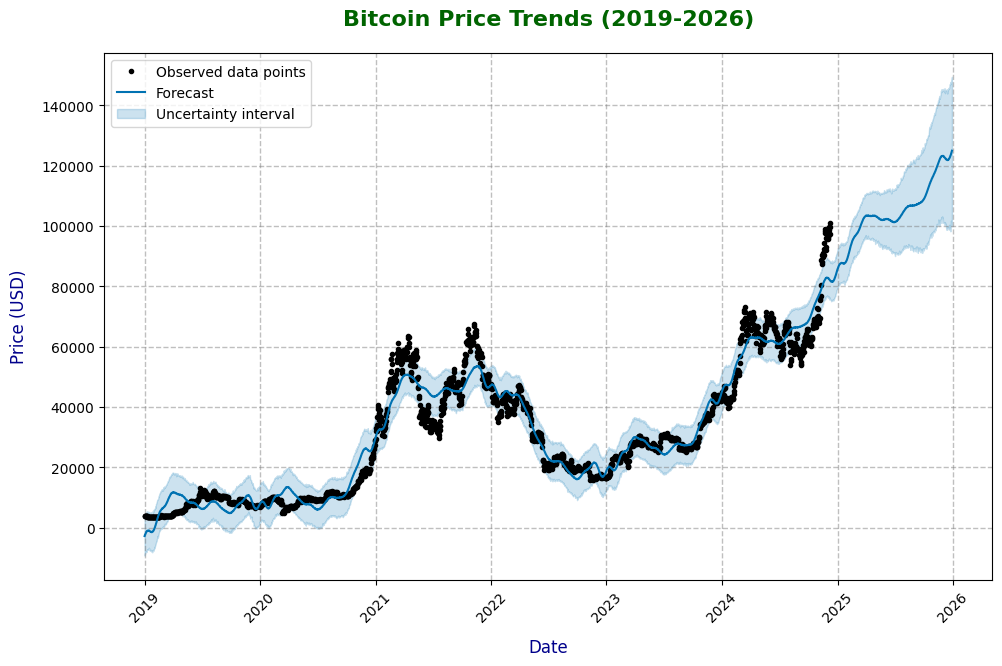

In [72]:
# From the forecast_bitcoin_trends DataFrame, plot the data to visualize
m.plot(forecast_bitcoin_trends);

plt.xlabel("Date", fontsize=12, labelpad=10, color='darkblue')  # Label font and spacing
plt.ylabel("Price (USD)", fontsize=12, labelpad=10, color='darkblue')  # Label font and spacing
plt.title("Bitcoin Price Trends (2019-2026)", fontsize=16, fontweight='bold', color='darkgreen', pad=20)  # Bold and larger title
# Formatting x-axis for better readability
plt.xticks(rotation=45, fontsize=10)  # Rotate x-ticks
# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid with light styling
plt.legend(loc='upper left', fontsize=10)  # Add legend
plt.show()

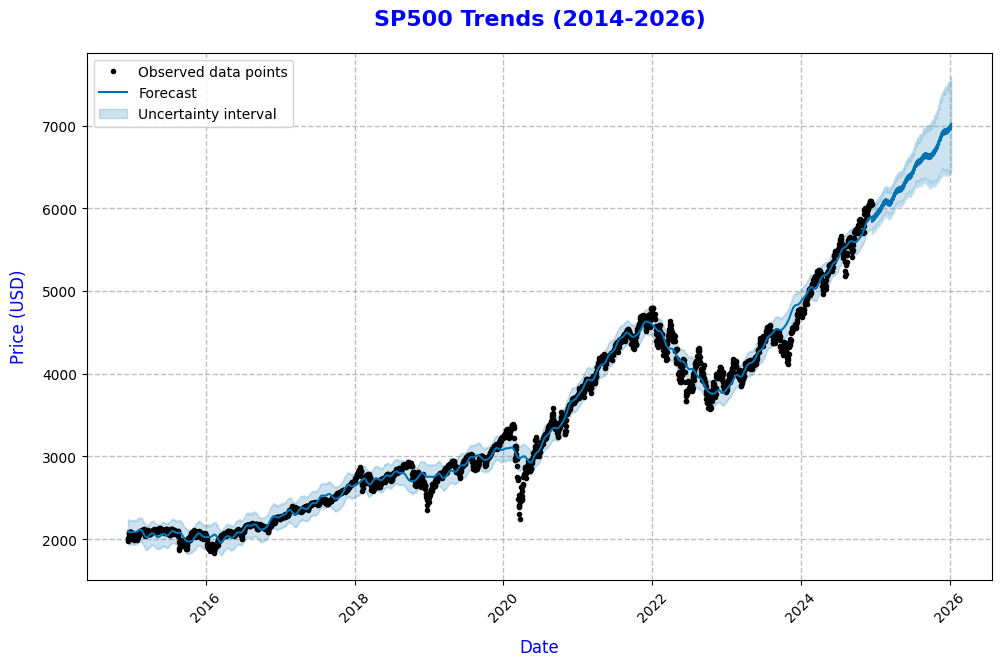

In [102]:
# From the forecast_sp500_trends DataFrame, plot the data to visualize
m1.plot(forecast_sp500_trends);
plt.xlabel("Date", fontsize=12, labelpad=10, color='blue')  # Label font and spacing
plt.ylabel("Price (USD)", fontsize=12, labelpad=10, color='blue')  # Label font and spacing
plt.title("SP500 Trends (2014-2026)", fontsize=16, fontweight='bold', color='Blue', pad=20)  # Bold and larger title
# Formatting x-axis for better readability
plt.xticks(rotation=45, fontsize=10)  # Rotate x-ticks
# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid with light styling
plt.legend(loc='upper left', fontsize=10)  # Add legend
plt.show()



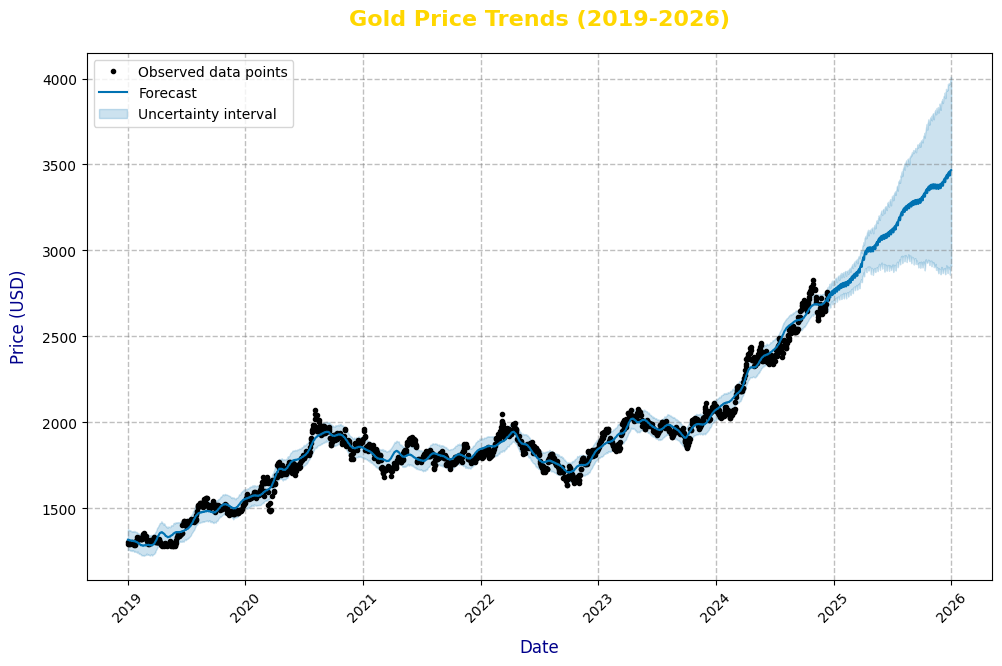

In [106]:
# From the forecast_gold_trends DataFrame, plot the data to visualize
m2.plot(forecast_gold_trends)

plt.xlabel("Date", fontsize=12, labelpad=10, color='darkblue')  # Label font and spacing
plt.ylabel("Price (USD)", fontsize=12, labelpad=10, color='darkblue')  # Label font and spacing
plt.title("Gold Price Trends (2019-2026)", fontsize=16, fontweight='bold', color='gold', pad=20)  # Bold and larger title

# Formatting x-axis for better readability
plt.xticks(rotation=45, fontsize=10)  # Rotate x-ticks

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid with light styling
plt.legend(loc='upper left', fontsize=10)  # Add legend

plt.show()

**Add Stock Volatility to the analysis**

In [107]:
# For Bitcoin, Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
bitcoin_df['Stock Volatility'] = bitcoin_df['Price'].rolling(window=4).std()
bitcoin_df.head()

,Date,Price,Open,High,Low,Volume,Stock Volatility
0,2021-08-03,38130.3,39167.4,39766.6,37688.2,260.0,NaN
1,2020-12-25,24689.6,23728.7,24778.9,23445.3,2400.0,NaN
2,2021-08-16,45996.3,46991.6,48002.4,45672.1,2410.0,NaN
3,2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0,10692.556843
4,2023-08-12,29428.2,29420.8,29480.8,29375.4,11070.0,11836.908845


In [129]:
# Create a new Bitcoin Dataframe with an index of date to properly display in stock volatility
bitcoin_df_volatility = bitcoin_df

# Set the index to date
bitcoin_df_volatility = bitcoin_df_volatility.set_index('Date')

# Sort the values by Date and ascending in order
bitcoin_df_volatility = bitcoin_df_volatility.sort_values(by='Date', ascending=True)

bitcoin_df_volatility.head()

,Price,Open,High,Low,Volume,Stock Volatility
Date,,,,,,
2019-01-01,3809.4,3709.5,3814.3,3664.4,469110.0,7234.628001
2019-01-02,3873.8,3809.7,3894.8,3768.1,554470.0,4157.198375
2019-01-03,3780.1,3874.1,3875.8,3753.0,450320.0,7523.925269
2019-01-04,3802.7,3780.5,3823.9,3720.0,488700.0,2120.218408
2019-01-05,3785.4,3802.8,3846.7,3769.0,468450.0,5548.514732


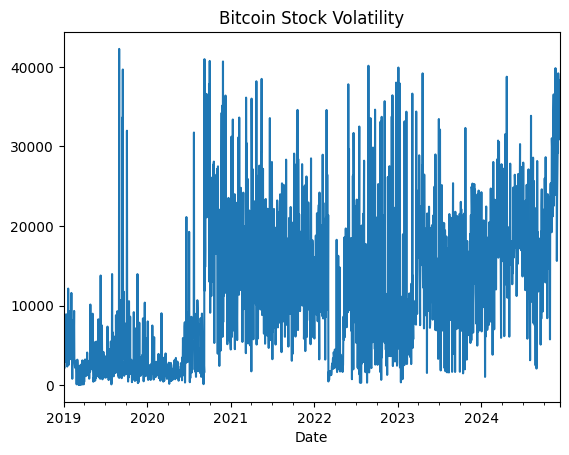

In [130]:
# Visualize the stock volatility
bitcoin_df_volatility['Stock Volatility'].plot(title="Bitcoin Stock Volatility");

In [131]:
# For SP500, Create a new column in the DataFrame called Stock Volatility for SP500
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
sp500_df['Stock Volatility'] = sp500_df['Price'].rolling(window=4).std()


In [125]:
# Create a new SP500 Dataframe with an index of date to properly display in stock volatility
sp500_df_volatility = sp500_df

# Set the index to date
sp500_df_volatility = sp500_df_volatility.set_index('Date')

# Sort the values by Date and ascending in order
sp500_df_volatility = sp500_df_volatility.sort_values(by='Date', ascending=True)

sp500_df_volatility.head()

,Price,Open,High,Low,Stock Volatility
Date,,,,,
2014-12-15,1989.63,2005.03,2018.69,1982.26,0.348365
2014-12-16,1972.74,1986.71,2016.89,1972.56,1.481902
2014-12-17,2012.89,1973.77,2016.75,1973.77,0.717281
2014-12-18,2061.23,2018.98,2061.23,2018.98,0.107819
2014-12-19,2070.65,2061.04,2077.85,2061.03,1.016346


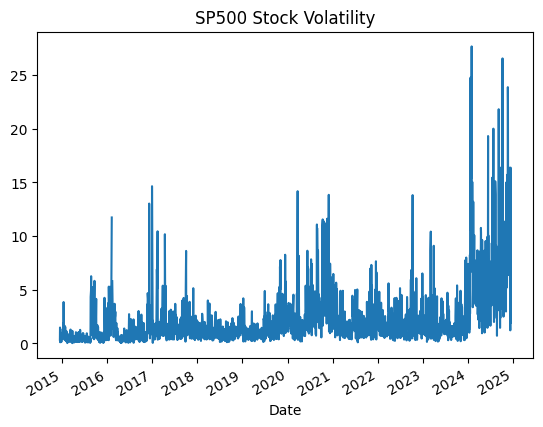

In [126]:
# Visualize the stock volatility for SP500
sp500_df_volatility['Stock Volatility'].plot(title="SP500 Stock Volatility");

In [132]:
# Create a new column in the gold DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
gold_df['Stock Volatility'] = gold_df['Price'].rolling(window=4).std()
gold_df.head()

,Date,Price,Open,High,Low,Change %,Stock Volatility
0,2024-12-12,2748.3,2753.51,2760.91,2743.49,-0.30%,NaN
1,2024-12-11,2756.7,2721.20,2759.70,2719.10,1.41%,NaN
2,2024-12-10,2718.4,2684.40,2721.70,2680.70,1.21%,NaN
3,2024-12-09,2685.8,2665.00,2700.00,2649.70,0.99%,32.180843
4,2024-12-06,2659.6,2655.00,2667.90,2635.60,0.42%,41.961043


In [133]:
# Create a new gold Dataframe with an index of date to properly display in stock volatility
gold_df_volatility = gold_df

# Set the index to date
gold_df_volatility = gold_df_volatility.set_index('Date')

# Sort the values by Date and ascending in order
gold_df_volatility = gold_df_volatility.sort_values(by='Date', ascending=True)

gold_df_volatility.head()

,Price,Open,High,Low,Change %,Stock Volatility
Date,,,,,,
2019-01-02,1290.5,1291.4,1297.0,1287.0,0.22%,4.777290
2019-01-03,1301.2,1293.5,1302.8,1292.8,0.83%,4.234383
2019-01-04,1292.2,1301.4,1306.5,1284.6,-0.69%,3.095561
2019-01-07,1296.4,1293.3,1303.2,1290.7,0.33%,2.680019
2019-01-08,1292.4,1296.4,1297.2,1286.7,-0.31%,2.643861


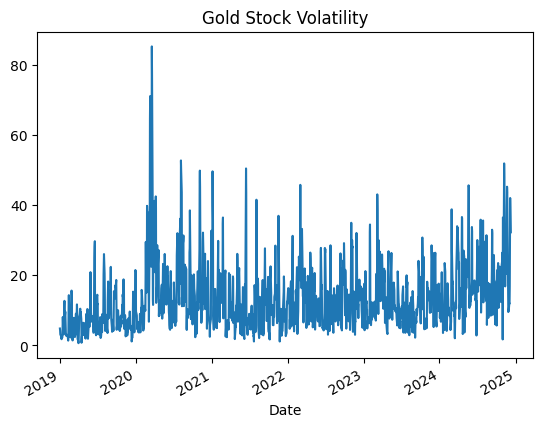

In [134]:
# Visualize the stock volatility
gold_df_volatility['Stock Volatility'].plot(title="Gold Stock Volatility");